### Importing data and connecting to mongodb (Bronze layer) 

In [2]:
pip install pymongo

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from pymongo import MongoClient

#Load CSV data into Pandas DataFrame
data = pd.read_csv("student_assessment_performance.csv")

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")  
db = client["demo"]  
collection = db["demo_coll"]  

# Insert Data into MongoDB
data_dict = data.to_dict(orient="records")
collection.insert_many(data_dict)
# Verify Data Import
print(f"Total Rows Imported: {collection.count_documents({})}")
print(f"Columns in the Dataset: {data.columns.tolist()}")

Total Rows Imported: 1943310
Columns in the Dataset: ['School Year', 'District Code', 'District', 'School Code', 'Organization', 'Assessment Name', 'ContentArea', 'Race', 'Gender', 'Grade', 'SpecialDemo', 'Geography', 'SubGroup', 'RowStatus', 'Tested', 'Proficient', 'PctProficient', 'ScaleScoreAvg']


### Data cleaning (Silver Layer)

In [4]:
# fill NaN values
numerical_cols = ["Tested", "Proficient", "PctProficient", "ScaleScoreAvg"]
for col in numerical_cols:
    data[col] = data[col].fillna(data[col].mean())

object_cols = ["District", "Organization", "Assessment Name", "ContentArea", 
               "Race", "Gender", "Grade", "SpecialDemo", "Geography", 
               "SubGroup", "RowStatus"]
data[object_cols] = data[object_cols].fillna("Unknown")

data["Gender"] = data["Gender"].str.capitalize()

# Reload cleaned data into MongoDB
client = MongoClient("mongodb://localhost:27017/")  
db = client["demo"]  # Database name
collection = db["cleaned_demo_coll"]  
# Delete existing documents if any
collection.delete_many({})

# Insert cleaned data
cleaned_data_dict = data.to_dict(orient="records")
collection.insert_many(cleaned_data_dict)

#Verify the data in MongoDB
total_rows = collection.count_documents({})
print(f"Total Rows after Cleaning: {total_rows}")

Total Rows after Cleaning: 1943310


### Aggregations(Gold Layer)

In [5]:
import matplotlib.pyplot as plt

# Average ScaleScoreAvg per District
pipeline_1 = [
    {"$group": {"_id": "$District", "AverageScaleScore": {"$avg": "$ScaleScoreAvg"}}},
    {"$sort": {"AverageScaleScore": -1}},
    {"$limit": 10}  
]
result_1 = list(collection.aggregate(pipeline_1))

# Total Proficient Students grouped by ContentArea and Race
pipeline_2 = [
    {"$group": {"_id": {"ContentArea": "$ContentArea", "Race": "$Race"},
                "TotalProficient": {"$sum": "$Proficient"}}},
    {"$sort": {"TotalProficient": -1}}
]
result_2 = list(collection.aggregate(pipeline_2))

# Percentage of Proficient students grouped by Gender
pipeline_3 = [
    {"$group": {"_id": "$Gender", 
                "TotalProficient": {"$sum": "$Proficient"}, 
                "TotalTested": {"$sum": "$Tested"}}},
    {"$project": {"ProficiencyPercentage": 
                  {"$multiply": [{"$divide": ["$TotalProficient", "$TotalTested"]}, 100]}}}
]
result_3 = list(collection.aggregate(pipeline_3))

# Print the results
print("Aggregation 1: Average ScaleScoreAvg per District")
print(result_1)

print("\nAggregation 2: Total Proficient Students by ContentArea and Race")
print(result_2)

print("\nAggregation 3: Proficiency Percentage by Gender")
print(result_3)

Aggregation 1: Average ScaleScoreAvg per District
[{'_id': 'Campus Community Charter School', 'AverageScaleScore': 1888.3904835278777}, {'_id': 'Family Foundations Academy', 'AverageScaleScore': 1885.6822890200112}, {'_id': 'Sussex Academy of Arts & Sciences', 'AverageScaleScore': 1799.8397733770798}, {'_id': 'Reach Academy for Girls', 'AverageScaleScore': 1758.0337398012675}, {'_id': 'Kuumba Academy Charter School', 'AverageScaleScore': 1736.125995399604}, {'_id': 'Charter School of New Castle', 'AverageScaleScore': 1734.0103959307432}, {'_id': 'Providence Creek Academy Charter School', 'AverageScaleScore': 1730.710845160526}, {'_id': 'First State Montessori Academy', 'AverageScaleScore': 1723.3288453831858}, {'_id': 'East Side Charter School', 'AverageScaleScore': 1718.8324685138743}, {'_id': 'Edison (Thomas A.) Charter School', 'AverageScaleScore': 1712.606026837472}]

Aggregation 2: Total Proficient Students by ContentArea and Race
[{'_id': {'ContentArea': 'ELA', 'Race': 'All Stude

### Visualizations

### Scatter Plot - ScaleScoreAvg vs PctProficient

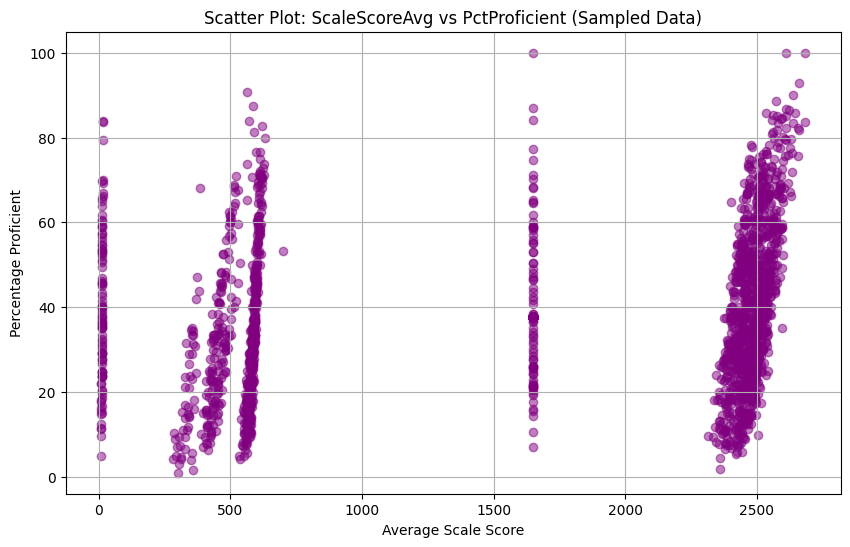

In [6]:
data = pd.DataFrame(list(collection.find()))
sampled_data = data.sample(n=10000, random_state=42)

plt.figure(figsize=(10, 6))
plt.scatter(sampled_data['ScaleScoreAvg'], sampled_data['PctProficient'], color='purple', alpha=0.5)
plt.title("Scatter Plot: ScaleScoreAvg vs PctProficient (Sampled Data)")
plt.xlabel("Average Scale Score")
plt.ylabel("Percentage Proficient")
plt.grid(True)
plt.show()

# Line Chart - ScaleScoreAvg over School Year

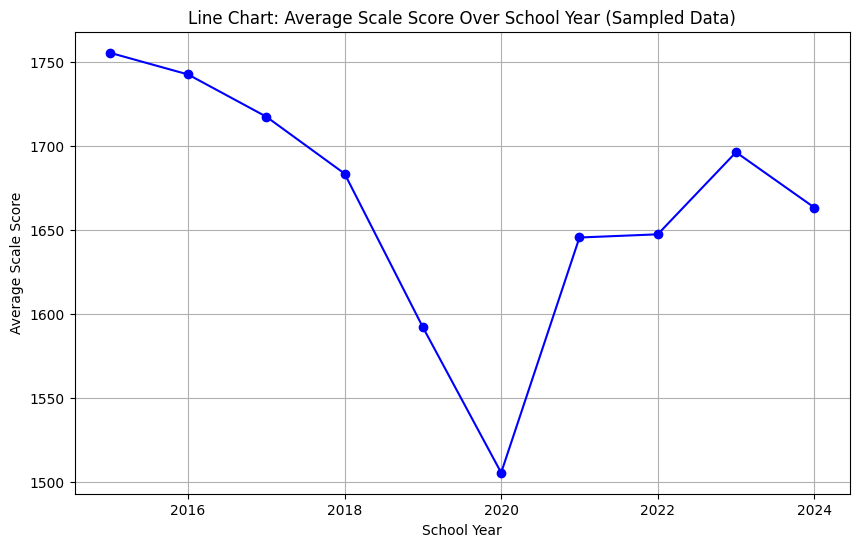

In [7]:
line_data = sampled_data.groupby("School Year")["ScaleScoreAvg"].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(line_data['School Year'], line_data['ScaleScoreAvg'], marker='o', color='blue', linestyle='-')
plt.title("Line Chart: Average Scale Score Over School Year (Sampled Data)")
plt.xlabel("School Year")
plt.ylabel("Average Scale Score")
plt.grid(True)
plt.show()

### Bubble Chart - Proficient vs Tested (Bubble size: PctProficient)

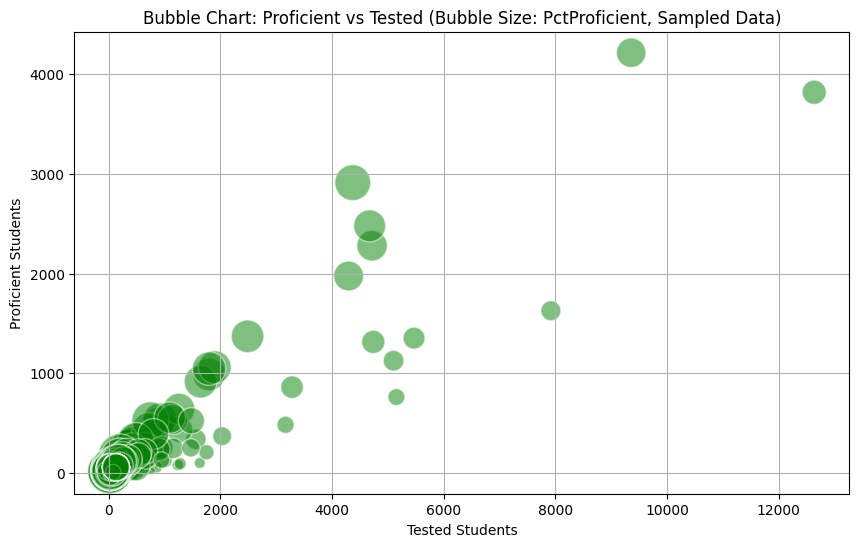

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(sampled_data['Tested'], sampled_data['Proficient'], 
            s=sampled_data['PctProficient'] * 10,
            alpha=0.5, c='green', edgecolors="w")
plt.title("Bubble Chart: Proficient vs Tested (Bubble Size: PctProficient, Sampled Data)")
plt.xlabel("Tested Students")
plt.ylabel("Proficient Students")
plt.grid(True)
plt.show()

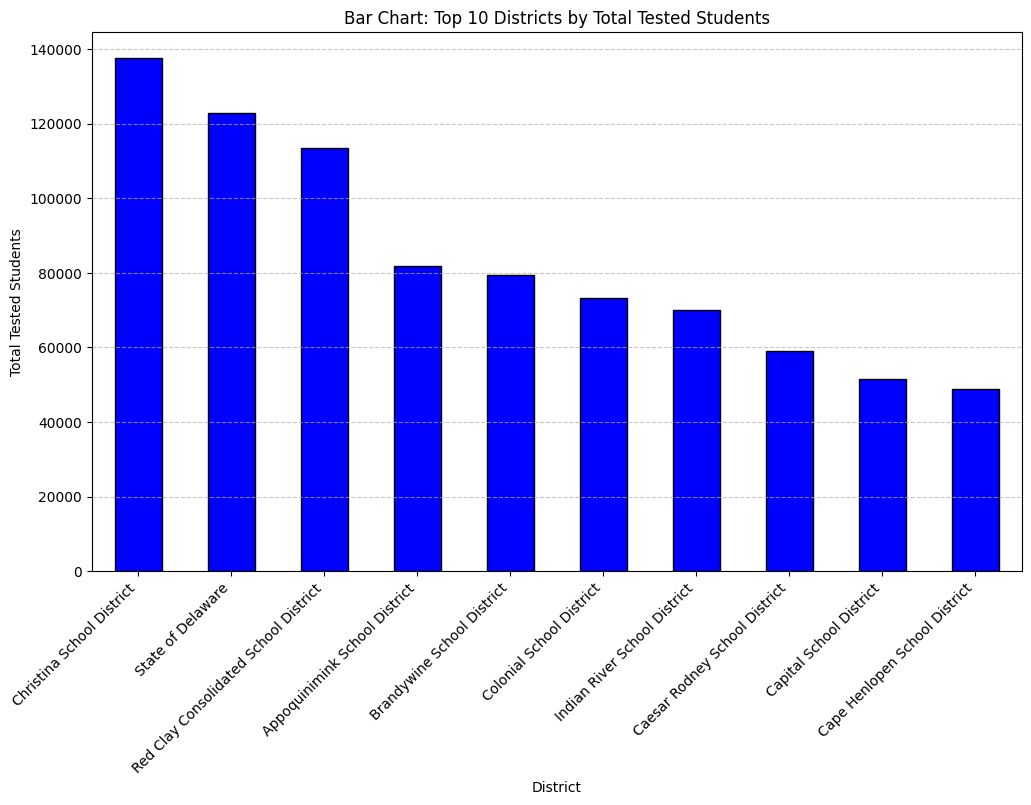

In [9]:
# Bar Chart: Top 10 Districts by Total Tested Students
top_districts_tested = sampled_data.groupby("District")["Tested"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 7))
top_districts_tested.plot(kind="bar", color="blue", edgecolor="black")
plt.title("Bar Chart: Top 10 Districts by Total Tested Students")
plt.xlabel("District")
plt.ylabel("Total Tested Students")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return 100 * (abs((y_true - y_pred) / y_true).mean())

# Select relevant features and target variable
features = sampled_data[["Tested", "Proficient", "ScaleScoreAvg"]]
target = sampled_data["PctProficient"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)

# Print Evaluation Metrics
print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (Accuracy): {r2:.2f}")

# Interpreting R-squared
print(f"\nThe model explains {r2*100:.2f}% of the variance in the data.")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 2.71
Mean Squared Error (MSE): 55.19
R-squared (Accuracy): 0.14

The model explains 14.50% of the variance in the data.


Random Forest Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.42
Mean Squared Error (MSE): 3.71
R-squared (Accuracy): 0.94
Mean Absolute Percentage Error (MAPE): 1.19%

The model explains 94.26% of the variance in the data.

Feature Importance:
Tested: 0.3358
Proficient: 0.3839
ScaleScoreAvg: 0.2803


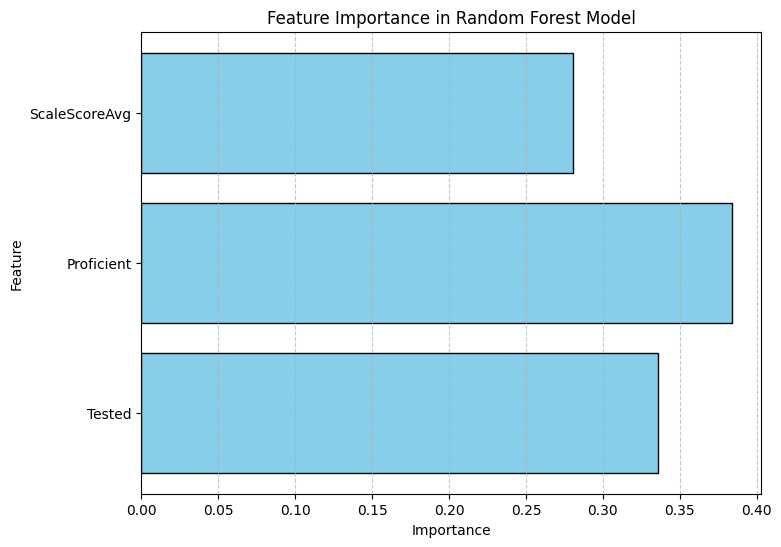

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return 100 * (abs((y_true - y_pred) / y_true).mean())

# Select relevant features and target variable
features = sampled_data[["Tested", "Proficient", "ScaleScoreAvg"]]
target = sampled_data["PctProficient"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make Predictions
y_pred = rf_model.predict(X_test)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)

# Print Evaluation Metrics
print("Random Forest Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (Accuracy): {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Interpreting R-squared
print(f"\nThe model explains {r2*100:.2f}% of the variance in the data.")

# Feature Importance
importances = rf_model.feature_importances_
feature_names = features.columns

print("\nFeature Importance:")
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

# Plot Feature Importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances, color='skyblue', edgecolor='black')
plt.title("Feature Importance in Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


               Model       MAE        MSE        R²  MAPE (%)
0  Linear Regression  2.711852  55.186632  0.144974  10.56762
1      Random Forest  0.415848   3.706496  0.942574   1.19345


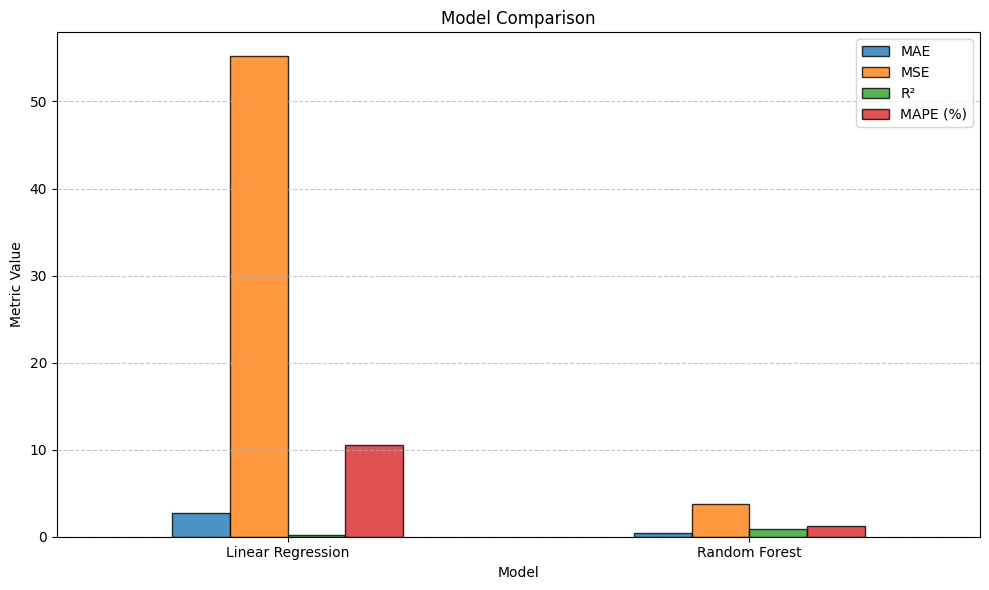

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return 100 * (abs((y_true - y_pred) / y_true).mean())

# Select relevant features and target variable
features = sampled_data[["Tested", "Proficient", "ScaleScoreAvg"]]
target = sampled_data["PctProficient"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Evaluate Both Models
metrics = {
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [
        mean_absolute_error(y_test, lr_pred),
        mean_absolute_error(y_test, rf_pred),
    ],
    "MSE": [
        mean_squared_error(y_test, lr_pred),
        mean_squared_error(y_test, rf_pred),
    ],
    "R²": [
        r2_score(y_test, lr_pred),
        r2_score(y_test, rf_pred),
    ],
    "MAPE (%)": [
        calculate_mape(y_test, lr_pred),
        calculate_mape(y_test, rf_pred),
    ],
}

# Convert metrics to a DataFrame for better visualization
import pandas as pd

metrics_df = pd.DataFrame(metrics)

# Print Comparison Table
print(metrics_df)

# Plot Comparison
import matplotlib.pyplot as plt

metrics_df.set_index("Model").plot(kind="bar", figsize=(10, 6), edgecolor="black", alpha=0.8)
plt.title("Model Comparison")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
